In [1]:
import os
import math
from random import randint
import shutil
import numpy as np

import librosa
import librosa.display

import tensorflow as tf
from tensorflow import keras

import pickle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from pathlib import Path
from IPython.display import display, Audio

import matplotlib.pyplot as plt
from tqdm import tqdm



physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Get the data from https://www.kaggle.com/kongaevans/speaker-recognition-dataset/download
# and save it to the 'Downloads' folder in your HOME directory
DATASET_ROOT = os.path.join("16000_pcm_speeches")

# The folders in which we will put the audio samples and the noise samples
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

# Percentage of samples to use for validation
VALID_SPLIT = 0.1

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

# The sampling rate to use.
# This is the one used in all of the audio samples.
# We will resample all of the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:
#   noisy_sample = sample + noise * prop * scale
#      where prop = sample_amplitude / noise_amplitude
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 20


#PART 1 - Speaker Identification using FFT and Neueral Network


In [2]:
 #If folder `audio`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)

# If folder `noise`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # If folder is `audio` or `noise`, do nothing
            continue
        elif folder in ["other", "_background_noise_"]:
            # If folder is one of the folders that contains noise samples,
            # move it to the `noise` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            # Otherwise, it should be a speaker folder, then move it to
            # `audio` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

In [3]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Found 6 files belonging to 2 directories


In [4]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)

# Split noise into chunks of 16,000 steps each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 354 noise samples where each is 1 sec. long


In [5]:

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

Our class names: ['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela']
Processing speaker Benjamin_Netanyau
Processing speaker Jens_Stoltenberg
Processing speaker Julia_Gillard
Processing speaker Magaret_Tarcher
Processing speaker Nelson_Mandela
Found 7501 files belonging to 5 classes.
Using 6751 files for training.
Using 750 files for validation.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [6]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 8000, 16)     64          input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 8000, 16)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 8000, 16)     784         activation[0][0]                 
______________________________________________________________________________________________

In [7]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/20
53/53 [==============================] - 14s 173ms/step - loss: 3.4095 - accuracy: 0.4739 - val_loss: 0.4258 - val_accuracy: 0.8240
Epoch 2/20
53/53 [==============================] - 9s 149ms/step - loss: 0.3794 - accuracy: 0.8613 - val_loss: 0.2860 - val_accuracy: 0.8880
Epoch 3/20
53/53 [==============================] - 9s 149ms/step - loss: 0.2359 - accuracy: 0.9103 - val_loss: 0.1722 - val_accuracy: 0.9227
Epoch 4/20
53/53 [==============================] - 9s 151ms/step - loss: 0.1407 - accuracy: 0.9420 - val_loss: 0.2063 - val_accuracy: 0.9187
Epoch 5/20
53/53 [==============================] - 9s 151ms/step - loss: 0.1778 - accuracy: 0.9282 - val_loss: 0.1753 - val_accuracy: 0.9400
Epoch 6/20
53/53 [==============================] - 9s 151ms/step - loss: 0.1081 - accuracy: 0.9555 - val_lo

In [8]:
print(model.evaluate(valid_ds))

24/24 [==============================] - 1s 19ms/step - loss: 0.0947 - accuracy: 0.9747
[0.09472725540399551, 0.9746666550636292]


In [9]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher


Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela


Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela


In [10]:
from keras.models import load_model
model.save("speaker_identifier_cnn.h5")

Using TensorFlow backend.


# PART 2 - Speaker Identification using MFCC and SVM.

In [11]:
#Method to read all noises from the folder
def getNoises(directory):
  noises = list()
  for idx,(dirpath, dirnames, filenames) in enumerate(os.walk(directory)):
    for files in filenames:
      path = os.path.join(dirpath,files)
      noise,sr = librosa.load(path)
      noises.append(noise)
  np.array(noises)
  return np.array(noises)

#This is to mix the noise with audio
def RandomCutNoise(noise,size):
  start_index = randint(0,(noise.size - size))
  end_index = start_index+size
  new_noise = noise[start_index:end_index]
  return new_noise

def MixNoise(audio,noise):
  size = audio.shape[0]
  slice_noise = RandomCutNoise(noise,size)
  noisy_audio = audio * np.random.uniform(0.8, 1.5) + slice_noise * np.random.uniform(0.1, 0.7)
  return noisy_audio

In [12]:
#Fetch all audios and labels
def getAudiosAndLabels(directory):
    audios = list()
    labels = list()
    sr_list = list()
    for idx,(dirpath, dirnames, filenames) in enumerate(os.walk(directory)):
        label = dirpath.split("/")[-1]
        for file in filenames:
            labels.append(label)
            path =  os.path.join(dirpath, file)
            signal, sr = librosa.load(path)
            sr_list.append(sr)
            audios.append(signal)
    return audios,labels,sr_list

#Create noisy dataset
def CreateAugmentedDataset(audios,noises,labels,sr_list):
    new_dataset = []
    new_labels = []
    for idx,audio in enumerate(audios):
      for jdx,noise in enumerate(noises):
        noisy_audio = MixNoise(audio,noise)
        new_dataset.append(CreateFeature(noisy_audio,sr_list[idx]))
        new_labels.append(labels[idx])
      if idx%1000==0:
        print("{} augmented data completed".format(idx))
    return new_dataset,new_labels

#Create dataset which contains mfcc and its delta..
def CreateFeature(signal,sr):
    """Reads and decodes an audio file to wave file."""
    #signal_trim = librosa.effects.remix(signal, intervals=librosa.effects.split(signal))
    mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    combined = np.empty((20,132))
    combined[:,:44] = mfcc
    combined[:,44:88] = mfcc_delta
    combined[:,88:] = mfcc_delta2
    return combined


def CreateDataset(data_directory,noise_directory):
  audios,labels,sr_list = getAudiosAndLabels(data_directory)
  noises = getNoises(noise_directory)
  dataset,labels = CreateAugmentedDataset(audios,noises,labels,sr_list)
  dataset = np.array(dataset)
  labels = np.array(labels)
  return dataset,labels



Creating dataset using supporting functions defined later. We use MFCC and delta as feature.

In [13]:
dataset,labels = CreateDataset(DATASET_AUDIO_PATH,DATASET_NOISE_PATH)

C:\Users\uajhi\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
C:\Users\uajhi\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


0 augmented data completed
1000 augmented data completed
2000 augmented data completed
3000 augmented data completed
4000 augmented data completed
5000 augmented data completed
6000 augmented data completed
7000 augmented data completed


In [14]:
#DATA preprocessing
labelMap = {}
for idx,label in enumerate(np.unique(labels)):
  labelMap[label]=idx
Y = [labelMap[label] for label in labels]
Y = np.array(Y)
X = dataset.reshape(dataset.shape[0],dataset.shape[1]*dataset.shape[2])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Use SVM classifier to identify the speaker

In [15]:
#classifier
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

Fit the model with the mfcc features

In [16]:
#model fitting
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

Compute both training and testing accuracy.

In [17]:
ytr_pred = clf.predict(X_train)


In [18]:
yte_pred = clf.predict(X_test)

In [19]:
print("Accuracy on train set : {}".format(np.mean(ytr_pred==y_train)*100))
print("Accuracy on test set : {}".format(np.mean(yte_pred==y_test)*100))

Accuracy on train set : 98.42806924454467
Accuracy on test set : 97.50201992997576


Save the model

In [20]:
filename = 'speaker_identifier.sav'
pickle.dump(clf, open(filename, 'wb'))

In [21]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

In [22]:
print("Accuracy using loaded model : {}".format(result*100))

Accuracy using loaded model : 97.50201992997576


A functon to predict the speaker.

In [23]:
def predict(path,labels):
  signal, sr = librosa.load(path)
  row = []
  mfcc = librosa.feature.mfcc(y=signal, sr=sr)
  mfcc_delta = librosa.feature.delta(mfcc)
  mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
  data = np.empty((20,132))
  data[:,:44] = mfcc
  data[:,44:88] = mfcc_delta
  data[:,88:] = mfcc_delta2
  data = data.reshape(data.shape[0]*data.shape[1])
  row.append(data)
  row = np.array(row)
  model = pickle.load(open('speaker_identifier.sav', 'rb'))
  result = model.predict(row)
  return labels[result[0]]

In [31]:
import random
labels = os.listdir(DATASET_AUDIO_PATH)
for filename in labels:
  audios = [files for files in os.listdir(os.path.join(DATASET_AUDIO_PATH,filename))]
  audio1 = random.choice(audios)
  audio2 = random.choice(audios)
  path1 = os.path.join(DATASET_AUDIO_PATH,filename,audio1)
  path2 = os.path.join(DATASET_AUDIO_PATH,filename,audio2)
  predicted1 = predict(path1,list(labelMap.keys()))
  predicted1 = predicted1.split('\\')[-1]
  predicted2 = predict(path2,list(labelMap.keys()))
  predicted2 = predicted2.split('\\')[-1]

  print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if filename == predicted1 else "[91m",
                filename,
                "[92m" if filename == predicted1 else "[91m",
                predicted1,
      )
  )
  display(Audio(path1, rate=SAMPLING_RATE))
  print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if filename == predicted2 else "[91m",
                filename,
                "[92m" if filename == predicted2 else "[91m",
                predicted2,
      )
  )
  display(Audio(path2, rate=SAMPLING_RATE))



Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg


Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher


Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela


C:\Users\uajhi\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


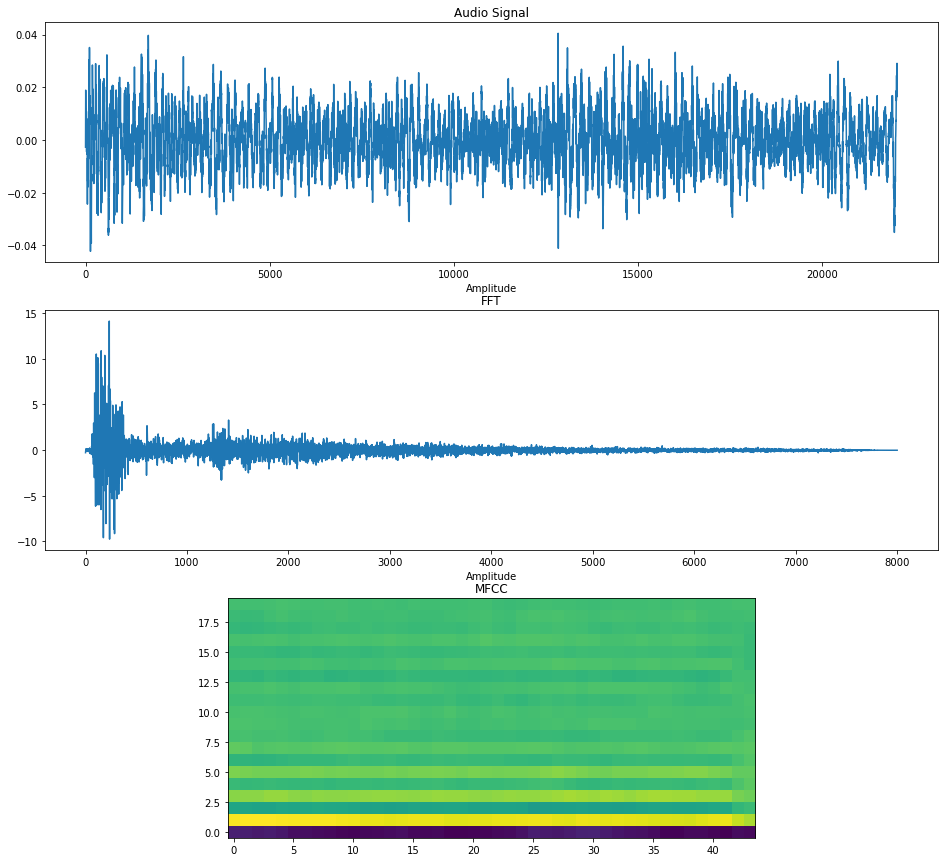

In [26]:
speaker = os.path.join(DATASET_AUDIO_PATH,'Benjamin_Netanyau','29.wav')
signal,sr = librosa.load(speaker)
fig,axes =  plt.subplots(nrows=3,figsize=(16,15))
axes[0].set_title("Audio Signal")
axes[0].plot(signal)
axes[0].set_xlabel("Amplitude")

signal_fft = path_to_audio(speaker)
audio = tf.squeeze(signal_fft, axis=-1)
fft = tf.signal.fft(
    tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
)
fft = tf.expand_dims(fft, axis=-1)
fft = fft[0:int(len(signal_fft)/2)]
axes[1].set_title("FFT")
axes[1].plot(fft)
axes[1].set_xlabel("Amplitude")

mfcc_data = librosa.feature.mfcc(y=signal, sr=sr)

axes[2].set_title("MFCC")
axes[2].imshow(mfcc_data, interpolation='nearest', origin='lower')


plt.show()